In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/vgame_fulldata.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import STOPWORDS
import gc
import re
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 📌 Data Import and Validation
---

### 📝 Import Data and Check Data Distribution

In [3]:
# train df
X_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv')

# test df
X_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv')
y_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv')

# val df
X_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv')
y_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv')

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

X_train shape: (117197, 2)
y_train shape: (117197, 12)

X_val shape: (14650, 2)
y_val shape: (14650, 12)

X_test shape: (14650, 2)
y_test shape: (14650, 12)



### 📝 Tiny EDA for Train, Test, and Validation Set

In [5]:
from ast import literal_eval

y_train['new_genrelist'] = y_train['new_genrelist'].apply(literal_eval)
y_test['new_genrelist'] = y_test['new_genrelist'].apply(literal_eval)
y_val['new_genrelist'] = y_val['new_genrelist'].apply(literal_eval)

In [6]:
genre_cols = ['action','adventure','arcade','cardboard','indie','puzzle','quiz','rpg','simulation','strategy']

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.798954,0.633864,0.916517,0.985588,0.566269,0.884792,0.992491,0.862104,0.737425,0.813818
1,0.201046,0.366136,0.083483,0.014412,0.433731,0.115208,0.007509,0.137896,0.262575,0.186182


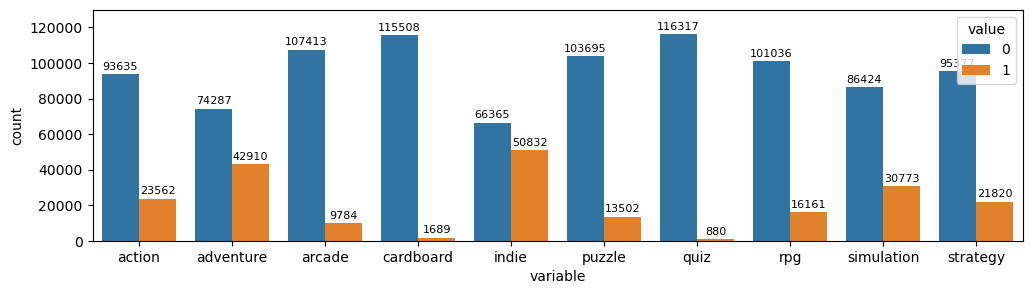

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

display(y_train[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_train[genre_cols]))
ax.set_ylim(0,130000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

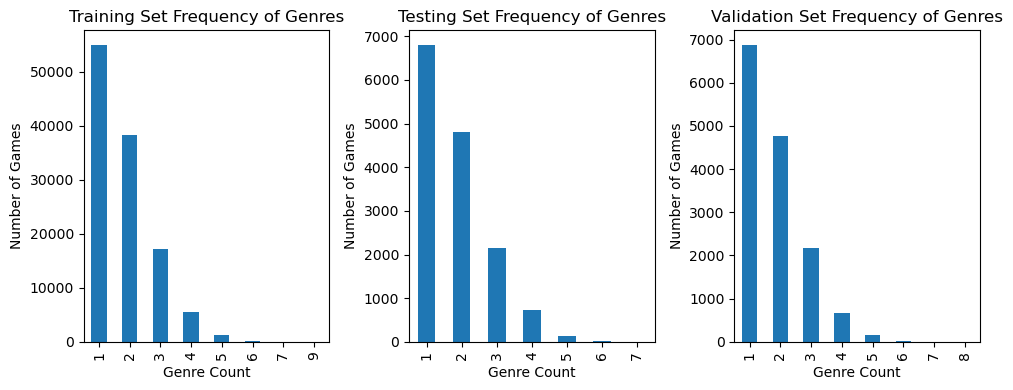

In [8]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

### 📝 Compile genre tags binary results to list then merge

In [9]:
y_train['compiled_genrelist'] = y_train[genre_cols].values.tolist()
y_val['compiled_genrelist'] = y_val[genre_cols].values.tolist()

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
merged_valset = pd.merge(X_val, y_val, on='id')[['clean_summary', 'compiled_genrelist']]

In [10]:
display(merged_trainset)
display(merged_valset)

,clean_summary,compiled_genrelist
0,a grid based single local multiplayer strategy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,top view racing game for wiiware by the makers...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,the idolmaster dearly stars is a japanese life...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,my daughter who was supposed to be dead is rig...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
4,espn baseball tonight is a baseball game with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
117192,kero kero king is the predecessor to ribbit ki...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117193,mighty chameleon brothers will remind you of o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
117194,take control of one of the iconic british loco...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117195,alchemist of war is a casual card game with cr...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


,clean_summary,compiled_genrelist
0,a new legend begins here build and manage a to...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1]"
1,meet barnsley a lazy good for nothing badger w...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fire up a wild ride across the cosmos with a f...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,a special bonus disc that contained the both t...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,kings cross a unique mix of strategy rpg and t...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...
14645,own the child of light ultimate edition with t...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]"
14646,a side scroller adventure game with a slight t...,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]"
14647,welcome to the chess game of tomorrow yesterye...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
14648,a capcom developed adventure game released exc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# 📌 Handling Dataset Imbalance
---

In [11]:
# import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# 📌 Preparation for Modelling
---

### 📝 Defining the Dataset Class

In [12]:
from torch.utils.data import Dataset, DataLoader

class MultiLabelDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = df
        self.text = df.clean_summary
        self.new_data = new_data
        self.max_len = max_len
        
        if not new_data:
            self.targets = self.data.compiled_genrelist
            
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        
        inputs = self.tokenizer.encode_plus(text,None,
                                           add_special_tokens=True,
                                           max_length=self.max_len,
                                           pad_to_max_length=True,
                                           return_token_type_ids=True,
                                           truncation=True)
        out = {
            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }
        if not self.new_data:
            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
            
        return out

### 📝 Defining the Configuration

In [13]:
MAX_LEN = 320
EPOCHS = 5
LEARNING_RATE = 1e-05
BATCH_SIZE = 32
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### 📝 Setting the Seeds

In [14]:
import os
import random
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### 📝 Tokenizing and Creating Dataset then Loading it to the DataLoader

In [15]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
train_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(merged_valset, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 📌 Model Development
---

### 📝 Defining DistilBERT Class Model

In [16]:
from transformers import DistilBertModel

class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                             torch.nn.ReLU(),
                                             torch.nn.Dropout(0.1),
                                             torch.nn.Linear(768, 10))
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:,0]
        out = self.classifier(out)
        return out

### 📝 Initializing the Model and Moving it to GPU

In [17]:
model = DistilBertClass()
model.to(DEVICE)
print(f"Model on {DEVICE}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on cuda:0


### 📝 Defining Optimizer and Loss Function

In [18]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

def loss_fn(outputs, targets):
    #return torch.nn.functional.binary_cross_entropy_with_logits(outputs,targets)
    alpha = 1
    gamma = 2
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma, logits=True)  # instantiate the FocalLoss class
    
    return focal_loss(outputs, targets)

### 📝 Defining Training Loop

In [19]:
train_epoch_losses = []
val_epoch_losses = []

In [20]:
from tqdm.auto import tqdm

train_loss_values = [[] for i in range(EPOCHS)]

def train(epoch):
    model.train()
    
    latest_loss = 0
    
    for _, data in tqdm(enumerate(train_loader)):
        input_ids = data['input_ids'].to(DEVICE, dtype=torch.long)
        attention_mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        if _ % 250 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            train_loss_values[epoch].append(loss.item())
        latest_loss = loss.item()
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    train_epoch_losses.append(latest_loss)

### 📝 Defining Validation Loop

In [21]:
from sklearn import metrics

def validate():
    model.eval()

    fin_targets = []
    fin_outputs = []
    latest_loss = 0

    with torch.inference_mode():
        for _, data in tqdm(enumerate(val_loader, 0)):
            ids = data['input_ids'].to(DEVICE, dtype=torch.long)
            mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
            targets = data['targets'].to(DEVICE, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            loss = loss_fn(outputs, targets)
            latest_loss = loss.item()
      
    fin_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')
    
    val_epoch_losses.append(latest_loss)

    return {
        "Accuracy Score": accuracy,
        "F1 score(micro)": f1_score_micro,
        "F1 score(macro)": f1_score_macro,
        "Validation Loss": latest_loss
    }

# 📌 Model Training/Finetuning
---

### 📝 Execute Training and Validation Process

In [22]:
for epoch in range(EPOCHS):
  train(epoch)
  print(validate())
  print('#' * 30)

0it [00:00, ?it/s]

Epoch: 0, Train Loss: 0.175418421626091
Epoch: 0, Train Loss: 0.08706981688737869
Epoch: 0, Train Loss: 0.06923922151327133
Epoch: 0, Train Loss: 0.08587430417537689
Epoch: 0, Train Loss: 0.08563496172428131
Epoch: 0, Train Loss: 0.08082740753889084
Epoch: 0, Train Loss: 0.08961383998394012
Epoch: 0, Train Loss: 0.0844407007098198
Epoch: 0, Train Loss: 0.09115488827228546
Epoch: 0, Train Loss: 0.07342896610498428
Epoch: 0, Train Loss: 0.06756242364645004
Epoch: 0, Train Loss: 0.07059323787689209
Epoch: 0, Train Loss: 0.059086885303258896
Epoch: 0, Train Loss: 0.06794164329767227
Epoch: 0, Train Loss: 0.06612777709960938


0it [00:00, ?it/s]

{'Accuracy Score': 0.34996587030716725, 'F1 score(micro)': 0.6615082962619384, 'F1 score(macro)': 0.5485395043583727, 'Validation Loss': 0.05215209349989891}
##############################


0it [00:00, ?it/s]

Epoch: 1, Train Loss: 0.0539054237306118
Epoch: 1, Train Loss: 0.05450236424803734
Epoch: 1, Train Loss: 0.07161314785480499
Epoch: 1, Train Loss: 0.06636927276849747
Epoch: 1, Train Loss: 0.07627846300601959
Epoch: 1, Train Loss: 0.052698828279972076
Epoch: 1, Train Loss: 0.07707380503416061
Epoch: 1, Train Loss: 0.050012290477752686
Epoch: 1, Train Loss: 0.06717478483915329
Epoch: 1, Train Loss: 0.06229711323976517
Epoch: 1, Train Loss: 0.06008018180727959
Epoch: 1, Train Loss: 0.06661421060562134
Epoch: 1, Train Loss: 0.06554942578077316
Epoch: 1, Train Loss: 0.053355347365140915
Epoch: 1, Train Loss: 0.07302878051996231


0it [00:00, ?it/s]

{'Accuracy Score': 0.3597952218430034, 'F1 score(micro)': 0.6811042069878782, 'F1 score(macro)': 0.5853089472617208, 'Validation Loss': 0.0482354611158371}
##############################


0it [00:00, ?it/s]

Epoch: 2, Train Loss: 0.05812835693359375
Epoch: 2, Train Loss: 0.053968578577041626
Epoch: 2, Train Loss: 0.05696558952331543
Epoch: 2, Train Loss: 0.06332935392856598
Epoch: 2, Train Loss: 0.0682670995593071
Epoch: 2, Train Loss: 0.05027694255113602
Epoch: 2, Train Loss: 0.0844152569770813
Epoch: 2, Train Loss: 0.05860033258795738
Epoch: 2, Train Loss: 0.07049336284399033
Epoch: 2, Train Loss: 0.05931931734085083
Epoch: 2, Train Loss: 0.056091904640197754
Epoch: 2, Train Loss: 0.06829635798931122
Epoch: 2, Train Loss: 0.06427547335624695
Epoch: 2, Train Loss: 0.06414668262004852
Epoch: 2, Train Loss: 0.04984230920672417


0it [00:00, ?it/s]

{'Accuracy Score': 0.38150170648464166, 'F1 score(micro)': 0.6848950758362767, 'F1 score(macro)': 0.5739409476054617, 'Validation Loss': 0.04944668710231781}
##############################


0it [00:00, ?it/s]

Epoch: 3, Train Loss: 0.06367010623216629
Epoch: 3, Train Loss: 0.05575854703783989
Epoch: 3, Train Loss: 0.05437026172876358
Epoch: 3, Train Loss: 0.05590379238128662
Epoch: 3, Train Loss: 0.041635334491729736
Epoch: 3, Train Loss: 0.05235783010721207
Epoch: 3, Train Loss: 0.05971870943903923
Epoch: 3, Train Loss: 0.06543959677219391
Epoch: 3, Train Loss: 0.07050063461065292
Epoch: 3, Train Loss: 0.055662062019109726
Epoch: 3, Train Loss: 0.05842326954007149
Epoch: 3, Train Loss: 0.05573243647813797
Epoch: 3, Train Loss: 0.06970534473657608
Epoch: 3, Train Loss: 0.05843494087457657
Epoch: 3, Train Loss: 0.07185736298561096


0it [00:00, ?it/s]

{'Accuracy Score': 0.3796587030716724, 'F1 score(micro)': 0.6960598503740648, 'F1 score(macro)': 0.599014531388333, 'Validation Loss': 0.0462801456451416}
##############################


0it [00:00, ?it/s]

Epoch: 4, Train Loss: 0.058803170919418335
Epoch: 4, Train Loss: 0.05405033752322197
Epoch: 4, Train Loss: 0.04676798731088638
Epoch: 4, Train Loss: 0.05731308460235596
Epoch: 4, Train Loss: 0.05312835052609444
Epoch: 4, Train Loss: 0.056127797812223434
Epoch: 4, Train Loss: 0.05237823724746704
Epoch: 4, Train Loss: 0.039540622383356094
Epoch: 4, Train Loss: 0.0571158342063427
Epoch: 4, Train Loss: 0.050055086612701416
Epoch: 4, Train Loss: 0.04887726530432701
Epoch: 4, Train Loss: 0.056369245052337646
Epoch: 4, Train Loss: 0.056320514529943466
Epoch: 4, Train Loss: 0.047665566205978394
Epoch: 4, Train Loss: 0.04822135344147682


0it [00:00, ?it/s]

{'Accuracy Score': 0.3776109215017065, 'F1 score(micro)': 0.6931924648659424, 'F1 score(macro)': 0.6013609619013276, 'Validation Loss': 0.05037733539938927}
##############################


# 📌 Model Testing/Predictions
---

### 📝 Creating Test Dataset then Loading it to the DataLoader

In [23]:
X_test

,id,clean_summary
0,169256,visit a variety of water attractions with jasm...
1,33905,how to play a game that doesn want to be playe...
2,81241,these are the last days of the first planet ex...
3,6601,it time to get the party started right with so...
4,69434,is a non interactive short simple story follow...
...,...,...
14645,158107,disc golf valley is home to some of the most b...
14646,52238,sequel to the hit game happy wars a game that ...
14647,164170,driiift your way through tons of obstacles and...
14648,137139,select characters have been chosen to debut as...


In [24]:
test_set = MultiLabelDataset(X_test, tokenizer, MAX_LEN, new_data=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

### 📝 Use Trained Model to Predict on Test Data

In [25]:
all_test_pred = []

def prediction():
  model.eval()

  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      outputs = model(ids, mask, token_type_ids)
      probas = torch.sigmoid(outputs)

      all_test_pred.append(probas)
  return probas
probabilities = prediction()

0it [00:00, ?it/s]

In [26]:
all_test_pred = torch.cat(all_test_pred)

In [27]:
submit_df = X_test.copy()
submit_df.drop('clean_summary', inplace=True, axis=1)

In [28]:
for i,name in enumerate(genre_cols):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [29]:
submit_df.to_csv('/kaggle/working/submission.csv', index=False)

In [30]:
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.037353,0.583891,0.030578,0.021561,0.617477,0.062034,0.013192,0.261228,0.520318,0.161054
1,33905,0.244871,0.408352,0.175009,0.095001,0.704994,0.332544,0.065506,0.272159,0.416358,0.460153
2,81241,0.340710,0.590403,0.161940,0.053286,0.662489,0.074040,0.034626,0.442635,0.142435,0.224648
3,6601,0.134103,0.199528,0.662973,0.293134,0.092877,0.281215,0.135609,0.142030,0.433789,0.225177
4,69434,0.089877,0.497147,0.056023,0.031347,0.670130,0.170463,0.032710,0.309560,0.407099,0.093754
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.060732,0.189558,0.222011,0.041267,0.426304,0.080327,0.018252,0.124455,0.936840,0.161718
14646,52238,0.384505,0.472166,0.213201,0.080100,0.506787,0.104449,0.048668,0.594752,0.165798,0.315546
14647,164170,0.424082,0.416326,0.327205,0.058159,0.485342,0.176839,0.051229,0.119903,0.359501,0.242262
14648,137139,0.127217,0.078090,0.151887,0.166415,0.077160,0.847861,0.133658,0.051094,0.199370,0.411299


# 📌 Model Evaluation
---

### 📝 Show Proababilities and Actual Values Dataframe

In [31]:
predictions_df = submit_df
predictions_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.037353,0.583891,0.030578,0.021561,0.617477,0.062034,0.013192,0.261228,0.520318,0.161054
1,33905,0.244871,0.408352,0.175009,0.095001,0.704994,0.332544,0.065506,0.272159,0.416358,0.460153
2,81241,0.340710,0.590403,0.161940,0.053286,0.662489,0.074040,0.034626,0.442635,0.142435,0.224648
3,6601,0.134103,0.199528,0.662973,0.293134,0.092877,0.281215,0.135609,0.142030,0.433789,0.225177
4,69434,0.089877,0.497147,0.056023,0.031347,0.670130,0.170463,0.032710,0.309560,0.407099,0.093754
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.060732,0.189558,0.222011,0.041267,0.426304,0.080327,0.018252,0.124455,0.936840,0.161718
14646,52238,0.384505,0.472166,0.213201,0.080100,0.506787,0.104449,0.048668,0.594752,0.165798,0.315546
14647,164170,0.424082,0.416326,0.327205,0.058159,0.485342,0.176839,0.051229,0.119903,0.359501,0.242262
14648,137139,0.127217,0.078090,0.151887,0.166415,0.077160,0.847861,0.133658,0.051094,0.199370,0.411299


In [32]:
actual_df = y_test
actual_df

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
1,33905,"[indie, puzzle]",0,0,0,0,1,1,0,0,0,0
2,81241,[adventure],0,1,0,0,0,0,0,0,0,0
3,6601,"[arcade, simulation]",0,0,1,0,0,0,0,0,1,0
4,69434,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,[simulation],0,0,0,0,0,0,0,0,1,0
14646,52238,[rpg],0,0,0,0,0,0,0,1,0,0
14647,164170,"[indie, simulation]",0,0,0,0,1,0,0,0,1,0
14648,137139,"[puzzle, strategy]",0,0,0,0,0,1,0,0,0,1


### 📝 Graph Training and Validation Losses

In [33]:
train_epoch_losses

[0.07247667014598846,
 0.07205774635076523,
 0.06630908697843552,
 0.04565856233239174,
 0.05166659504175186]

In [34]:
val_epoch_losses

[0.05215209349989891,
 0.0482354611158371,
 0.04944668710231781,
 0.0462801456451416,
 0.05037733539938927]

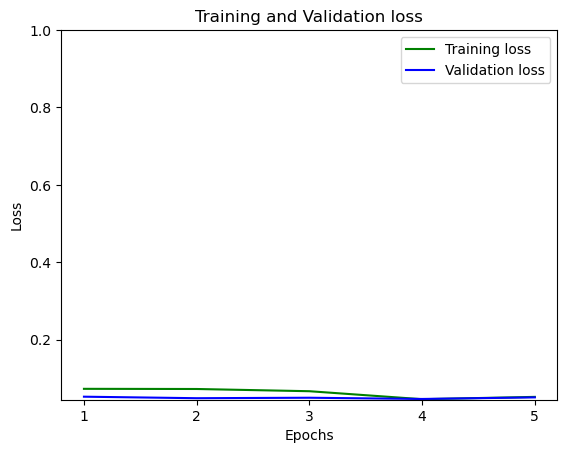

In [35]:
epochs = [str(x) for x in range(1,EPOCHS+1)]

fig, ax = plt.subplots()

ax.plot(epochs, train_epoch_losses, 'g', label='Training loss')
ax.plot(epochs, val_epoch_losses, 'b', label='Validation loss')

ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_ylim(top=1)
ax.legend()

plt.show()

### 📝 Calculate for AUC ROC Score

In [36]:
%pip install -q torchmetrics watermark

Note: you may need to restart the kernel to use updated packages.


In [37]:
%load_ext watermark

In [38]:
%watermark --iversions

re        : 2.2.1
torch     : 1.13.0
pandas    : 1.3.5
matplotlib: 3.5.3
numpy     : 1.21.6
seaborn   : 0.12.2
sklearn   : 1.0.2



In [39]:
# Score for each cat
import torchmetrics

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat])}")
    #print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.9020814984497659
torchmetrics score: 0.9020814895629883
##############################

Category: adventure
Sklearn score: 0.8749053619440403
torchmetrics score: 0.8749054074287415
##############################

Category: arcade
Sklearn score: 0.8509018558339566
torchmetrics score: 0.8509017825126648
##############################

Category: cardboard
Sklearn score: 0.9339649932020869
torchmetrics score: 0.9339650869369507
##############################

Category: indie
Sklearn score: 0.8770875639327419
torchmetrics score: 0.8770875334739685
##############################

Category: puzzle
Sklearn score: 0.8929613368707295
torchmetrics score: 0.8929612636566162
##############################

Category: quiz
Sklearn score: 0.9521866238992778
torchmetrics score: 0.9521865844726562
##############################

Category: rpg
Sklearn score: 0.899600395256917
torchmetrics score: 0.8996003866195679
##############################

Category: simulation
Skle

In [40]:
# mean column-wise score on all categories
print(f"Sklearn score(micro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")

Sklearn score(micro): 0.9239687113924266
torchmetrics score(micro): 0.9239686727523804

Sklearn score(macro): 0.8960664242581556
torchmetrics score(macro): 0.8960663676261902

Sklearn score(weighted): 0.8850858787977619
torchmetrics score(weighted): 0.8850858807563782


### 📝 Calculate for Average Precision Score

In [41]:
# score for each genre categories

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat])}")
    #print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_average_precision(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.7533393514053742
torchmetrics score: 0.7533393502235413
##############################

Category: adventure
Sklearn score: 0.807091424550634
torchmetrics score: 0.807091474533081
##############################

Category: arcade
Sklearn score: 0.45445233662703904
torchmetrics score: 0.4544523358345032
##############################

Category: cardboard
Sklearn score: 0.3942557537673511
torchmetrics score: 0.39425575733184814
##############################

Category: indie
Sklearn score: 0.8189873321214982
torchmetrics score: 0.8189873099327087
##############################

Category: puzzle
Sklearn score: 0.631117810823753
torchmetrics score: 0.6311178207397461
##############################

Category: quiz
Sklearn score: 0.45269469970541937
torchmetrics score: 0.45269471406936646
##############################

Category: rpg
Sklearn score: 0.6908353167364933
torchmetrics score: 0.6908352971076965
##############################

Category: simulation
Sk

In [42]:
# mean column-wise score on all categories
print()
print(f"Sklearn score(micro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")


Sklearn score(micro): 0.7704356882461987
torchmetrics score(micro): 0.7704356908798218

Sklearn score(macro): 0.6569457852086156
torchmetrics score(macro): 0.6569458246231079

Sklearn score(weighted): 0.7583909486540066
torchmetrics score(weighted): 0.7583910226821899


## ⚠ Beyond this point, I am thresholding the predictions to 0.5. Be warned.

In [43]:
thresholded_preds = predictions_df.copy()

for cat in genre_cols:
    thresholded_preds[cat] = (thresholded_preds[cat] >= 0.5).astype(int)

display(predictions_df)
display(thresholded_preds)

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.037353,0.583891,0.030578,0.021561,0.617477,0.062034,0.013192,0.261228,0.520318,0.161054
1,33905,0.244871,0.408352,0.175009,0.095001,0.704994,0.332544,0.065506,0.272159,0.416358,0.460153
2,81241,0.340710,0.590403,0.161940,0.053286,0.662489,0.074040,0.034626,0.442635,0.142435,0.224648
3,6601,0.134103,0.199528,0.662973,0.293134,0.092877,0.281215,0.135609,0.142030,0.433789,0.225177
4,69434,0.089877,0.497147,0.056023,0.031347,0.670130,0.170463,0.032710,0.309560,0.407099,0.093754
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.060732,0.189558,0.222011,0.041267,0.426304,0.080327,0.018252,0.124455,0.936840,0.161718
14646,52238,0.384505,0.472166,0.213201,0.080100,0.506787,0.104449,0.048668,0.594752,0.165798,0.315546
14647,164170,0.424082,0.416326,0.327205,0.058159,0.485342,0.176839,0.051229,0.119903,0.359501,0.242262
14648,137139,0.127217,0.078090,0.151887,0.166415,0.077160,0.847861,0.133658,0.051094,0.199370,0.411299


,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0,1,0,0,1,0,0,0,1,0
1,33905,0,0,0,0,1,0,0,0,0,0
2,81241,0,1,0,0,1,0,0,0,0,0
3,6601,0,0,1,0,0,0,0,0,0,0
4,69434,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0,0,0,0,0,0,0,0,1,0
14646,52238,0,0,0,0,1,0,0,1,0,0
14647,164170,0,0,0,0,0,0,0,0,0,0
14648,137139,0,0,0,0,0,1,0,0,0,0


### 📝 Getting Confusion Matrix

In [44]:
mlb_cm = metrics.multilabel_confusion_matrix(y_true=actual_df[genre_cols].values, y_pred=thresholded_preds[genre_cols].values)

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.797133,0.629283,0.912628,0.984573,0.568396,0.886212,0.992014,0.863481,0.736655,0.812082
1,0.202867,0.370717,0.087372,0.015427,0.431604,0.113788,0.007986,0.136519,0.263345,0.187918


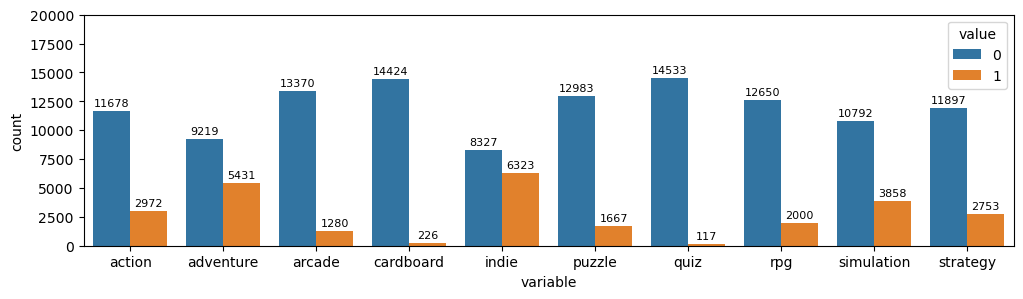

In [45]:
# displaying test set distribution as a proof of validation to our confusion matrices

display(y_test[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_test[genre_cols]))
ax.set_ylim(0,20000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

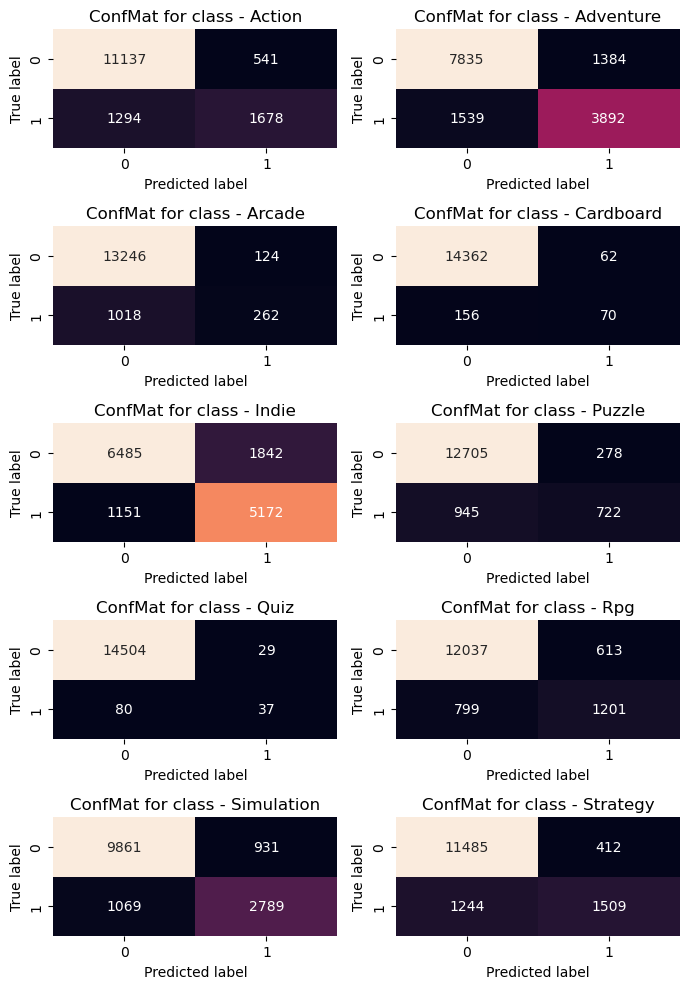

In [46]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    #heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    #heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("ConfMat for class - " + class_label.capitalize())
    
fig, ax = plt.subplots(5, 2, figsize=(7, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mlb_cm, genre_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()

### 📝 Classification Report

In [47]:
print(metrics.classification_report(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, target_names=genre_cols))

              precision    recall  f1-score   support

      action       0.76      0.56      0.65      2972
   adventure       0.74      0.72      0.73      5431
      arcade       0.68      0.20      0.31      1280
   cardboard       0.53      0.31      0.39       226
       indie       0.74      0.82      0.78      6323
      puzzle       0.72      0.43      0.54      1667
        quiz       0.56      0.32      0.40       117
         rpg       0.66      0.60      0.63      2000
  simulation       0.75      0.72      0.74      3858
    strategy       0.79      0.55      0.65      2753

   micro avg       0.74      0.65      0.69     26627
   macro avg       0.69      0.52      0.58     26627
weighted avg       0.73      0.65      0.68     26627
 samples avg       0.75      0.71      0.69     26627



### 📝 Getting F1 Score

In [48]:
for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.f1_score(actual_df[cat], thresholded_preds[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_f1_score(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values))}")
    #print(f"torchmetrics score(orig): {torchmetrics.functional.classification.binary_f1_score(torch.tensor(thresholded_preds[cat].values),torch.tensor(actual_df[cat].values), threshold=0.5)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.6465035638605279
torchmetrics score: 0.6465035676956177
##############################

Category: adventure
Sklearn score: 0.727001027365275
torchmetrics score: 0.7270010113716125
##############################

Category: arcade
Sklearn score: 0.31452581032412963
torchmetrics score: 0.3145258128643036
##############################

Category: cardboard
Sklearn score: 0.39106145251396646
torchmetrics score: 0.3910614550113678
##############################

Category: indie
Sklearn score: 0.7755867136537452
torchmetrics score: 0.775586724281311
##############################

Category: puzzle
Sklearn score: 0.54143232095988
torchmetrics score: 0.5414323210716248
##############################

Category: quiz
Sklearn score: 0.40437158469945356
torchmetrics score: 0.40437158942222595
##############################

Category: rpg
Sklearn score: 0.6297850026219193
torchmetrics score: 0.6297850012779236
##############################

Category: simulation
Skl

In [49]:
print(f"Sklearn score(micro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='micro')}")
print(f"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(macro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='macro')}")
print(f"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='weighted')}")
print(f"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='weighted')}")

Sklearn score(micro): 0.6908619830592925
torchmetrics score(micro): 0.5812045335769653

Sklearn score(macro): 0.5812045211766005
torchmetrics score(macro): 0.5812045335769653

Sklearn score(weighted): 0.6794459938092476
torchmetrics score(weighted): 0.6794459223747253
